In [1]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from volatility_arbitrage.pricing_model.heston_model import generate_inefficient_market
from volatility_arbitrage.pricing_model.interface import HestonParams, MarketModel
from volatility_arbitrage.pricing_model.weighted_variance_swap import VarianceSwap

# Model Setup

In [3]:
BDAYS = 252

length = BDAYS
time_delta = 1 / length
implied_vol = 0.2
realized_vol = 0.16
num_path = 10_000
rho_tilde = -0.8
rho = -0.6
vol_of_var = 0.5

real_model = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=vol_of_var, rho=-0.4)
imp_model = HestonParams(kappa=5, mean_of_var=implied_vol**2, vol_of_var=vol_of_var, rho=rho_tilde)

market_model = MarketModel(
    imp_model=imp_model, real_model=real_model, rho_real_var_imp_var=0.7, rho_spot_imp_var=rho
)

np.random.seed(0)
lr, real_var, imp_var = generate_inefficient_market(
    real_var_0=realized_vol**2,
    imp_var_0=implied_vol**2,
    market_model=market_model,
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

f = 100 * np.exp(np.cumsum(lr, axis=0))

# Realized Vol-Spot Covariance Estimation

In [4]:
def rolling_mean_columns(
    data: npt.NDArray[np.float64], window_size: int
) -> npt.NDArray[np.float64]:
    assert data.ndim == 2

    # Get the shape of the array
    n, k = data.shape

    # Calculate the new shape after applying the rolling window
    new_shape = (n - window_size + 1, window_size, k)

    # Use stride tricks to create a sliding window across rows
    strides = (data.strides[0],) + data.strides
    rolling_windows = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    # Compute the mean along the second axis (the rolling window axis)
    return rolling_windows.mean(axis=1)

In [5]:
variance_swap = VarianceSwap(market_model=market_model)
vol_est = np.sqrt(variance_swap.price(imp_var=imp_var, tau=1 / BDAYS) * BDAYS)
comovement = lr[1:] * np.diff(vol_est, axis=0)
real_cov = 0.5 * rho * np.sqrt(real_var[1:]) * vol_of_var

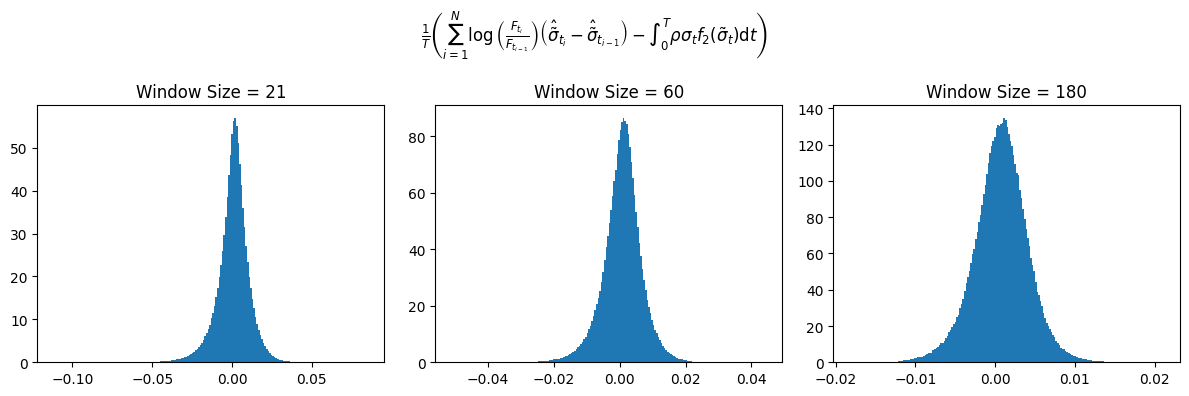

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, window_size in enumerate([21, 60, 180]):
    real_cov_est = rolling_mean_columns(comovement, window_size) / time_delta
    integrated_real_cov = rolling_mean_columns(real_cov, window_size)

    ax[i].hist((real_cov_est - integrated_real_cov).flatten(), density=True, bins=200)
    ax[i].set_title("Window Size = {}".format(window_size))

fig.suptitle(
    r"$\frac{1}{T}\left(\sum_{i=1}^N \log\left(\frac{F_{t_i}}{F_{t_{i-1}}}\right) \left(\hat{\tilde{\sigma}}_{t_i} -  \hat{\tilde{\sigma}}_{t_{i-1}}\right) - \int_0^T \rho \sigma_t f_2(\tilde{\sigma}_t) \mathrm{d} t\right)$"
)
fig.tight_layout()
plt.show()

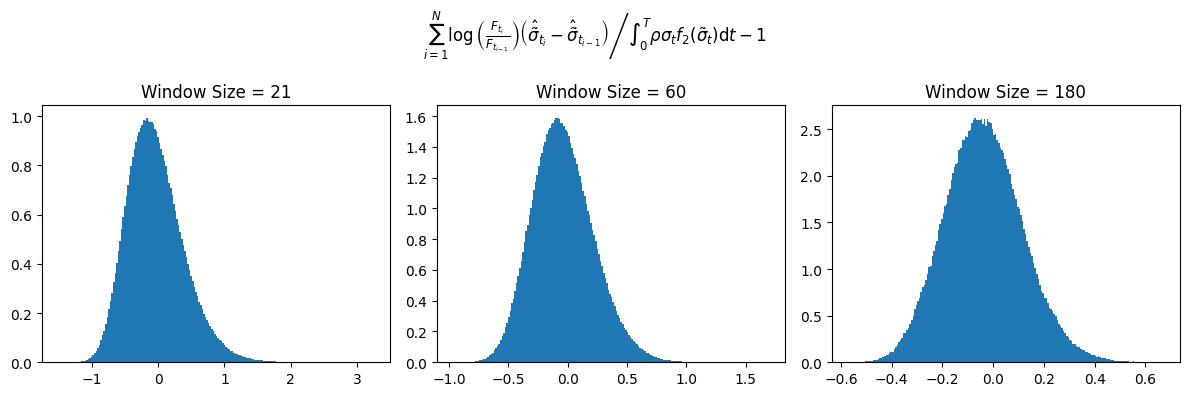

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, window_size in enumerate([21, 60, 180]):
    real_cov_est = rolling_mean_columns(comovement, window_size) / time_delta
    integrated_real_cov = rolling_mean_columns(real_cov, window_size)

    ax[i].hist((real_cov_est / integrated_real_cov - 1).flatten(), density=True, bins=200)
    ax[i].set_title("Window Size = {}".format(window_size))

fig.suptitle(
    r"$\left. \sum_{i=1}^N \log\left(\frac{F_{t_i}}{F_{t_{i-1}}}\right) \left(\hat{\tilde{\sigma}}_{t_i} -  \hat{\tilde{\sigma}}_{t_{i-1}}\right) \right/ \int_0^T \rho \sigma_t f_2(\tilde{\sigma}_t) \mathrm{d} t - 1$"
)
fig.tight_layout()
plt.show()